-=# Laboratory values vs outcome

Get the first laboratory measurements for patients admitted to the ICU. Plot the distribution of measurements for survival and non-survival groups.

In [3]:
# Import libraries
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import yaml
import os
from scipy.signal import medfilt

# used to print out pretty pandas dataframes
from IPython.display import display, HTML

%matplotlib inline
plt.style.use('ggplot')

font = {'family' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

## Functions

In [4]:
def stats(d, c, idx):
    avg_a = np.mean(df.loc[(df['data_source']=='anzics')&idx,c].dropna().values)
    avg_e = np.mean(df.loc[(df['data_source']=='eicu')&idx,c].dropna().values)
    avg_m = np.mean(df.loc[(df['data_source']=='mimic')&idx,c].dropna().values)
    avg_o = np.mean(df.loc[(df['data_source']=='orchestra')&idx,c].dropna().values)
    d[c+'_avg']= [avg_a, avg_e, avg_m, avg_o]
    std_a = np.std(df.loc[(df['data_source']=='anzics')&idx,c].dropna().values)
    std_e = np.std(df.loc[(df['data_source']=='eicu')&idx,c].dropna().values)
    std_m = np.std(df.loc[(df['data_source']=='mimic')&idx,c].dropna().values)
    std_o = np.std(df.loc[(df['data_source']=='orchestra')&idx,c].dropna().values)
    d[c+'_std']= [std_a, std_e, std_m, std_o]
    med_a = np.median(df.loc[(df['data_source']=='anzics')&idx,c].dropna().values)
    med_e = np.median(df.loc[(df['data_source']=='eicu')&idx,c].dropna().values)
    med_m = np.median(df.loc[(df['data_source']=='mimic')&idx,c].dropna().values)
    med_o = np.median(df.loc[(df['data_source']=='orchestra')&idx,c].dropna().values)
    d[c+'_med']= [med_a, med_e, med_m, med_o]
    return d, [avg_a,avg_e,avg_m,avg_o]

In [5]:
def counting(c):
    a = df.loc[(df['data_source']=='anzics'),c].dropna().count()
    e = df.loc[(df['data_source']=='eicu'),c].dropna().count()
    m = df.loc[(df['data_source']=='mimic'),c].dropna().count()
    o = df.loc[(df['data_source']=='orchestra'),c].dropna().count()
    return [a,e,m,o]

# Load in merged GOSSIS data

In [6]:
df = pd.read_csv('gossis-data.csv',header=0,sep=",")
df['data_source'].value_counts()

C:\Python27\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (1,6,7,9,10,16,18,19,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


eicu         130244
orchestra     59693
mimic         48660
anzics        14003
Name: data_source, dtype: int64

# Load in the header and the data type for each column

In [7]:
hdr = pd.read_csv('hdr/header.csv',header=None,sep=',')[0].values

# load yaml definitions
with open("hdr/variable-definitions.yaml", 'r') as stream:
    try:
        varlist = yaml.load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# convert to dataframe
df_var = pd.DataFrame.from_dict(varlist, orient='index')
df_var['varname'] = df_var.index

# specify the order of the categories - data is output in this order
category_order = {'identifier': 1,
                  'demographic': 2,
                  'APACHE covariate': 3,
                  'vitals': 4,
                  'labs': 5,
                  'labs blood gas': 6,
                  'APACHE prediction': 10}
df_var['category_order'] = df_var['category'].map(category_order)

# sort df by the category, then by the variable name
df_var.sort_values(['category_order','varname'],inplace=True)

In [8]:
df_var['category'].value_counts()

vitals               64
labs                 60
demographic          27
APACHE covariate     25
labs blood gas       16
identifier            4
APACHE prediction     4
Name: category, dtype: int64

In [9]:
df_var['dataType'].value_counts()

numeric    167
string      14
binary      11
integer      8
Name: dataType, dtype: int64

# Comparisons

For comparisons, we are interested assessing each variable across the databases.

For numeric/integer variables:

* Compare the mean, median, standard deviation, 5th and 95th percentiles
* Plot the distribution using histograms

For string/binary (categorical) variables:

* Compare the categories to see if they overlap
* Compare the frequency of each category (cross-tab)

## Compare APACHE-III score in eicu and anzics patients

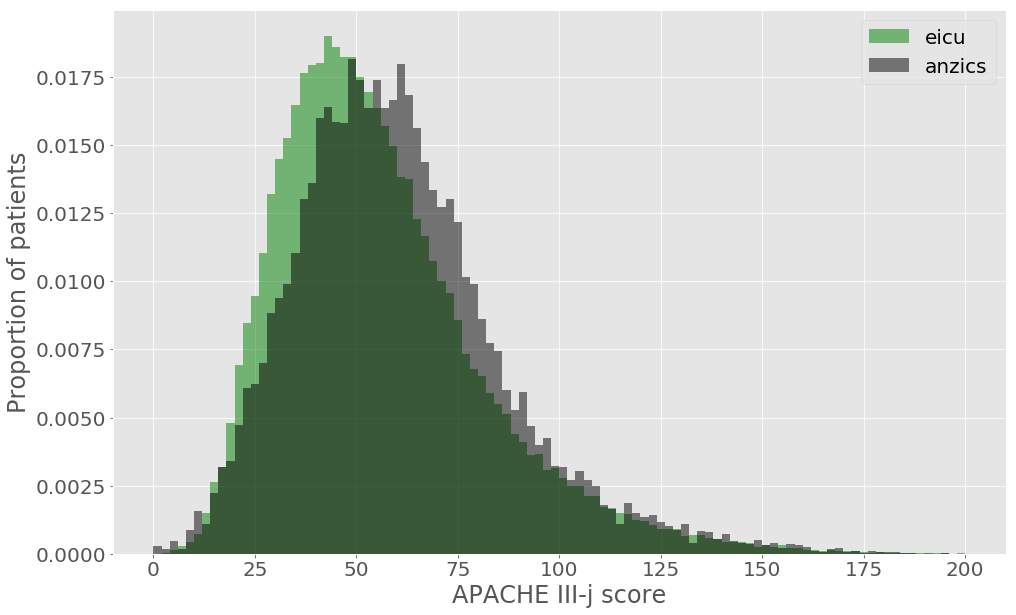

In [16]:
bins = np.linspace(0, 200, 101)
plt.figure(figsize=[16,10])
#plt.hist(df_all.loc[df_all['db']=='mimic','apsiii'].values, bins,
#         normed=True, alpha=0.5, label='mimic')
plt.hist(df.loc[df['data_source']=='eicu','apache_3j_score'].dropna().values, bins,
         normed=True, alpha=0.5, label='eicu', color = 'green')
plt.hist(df.loc[df['data_source']=='anzics','apache_3j_score'].dropna().values, bins,
         normed=True, alpha=0.5, label='anzics', color= 'black')
plt.legend(loc='upper right')
plt.xlabel('APACHE III-j score')
plt.ylabel('Proportion of patients')
plt.show()

As we can see the distributions are very similar, though ANZICS seems to have lower acuity.

C:\Python27\lib\site-packages\matplotlib\axes\_axes.py:6198: RuntimeWarning: invalid value encountered in true_divide
  m = (m.astype(float) / db) / m.sum()


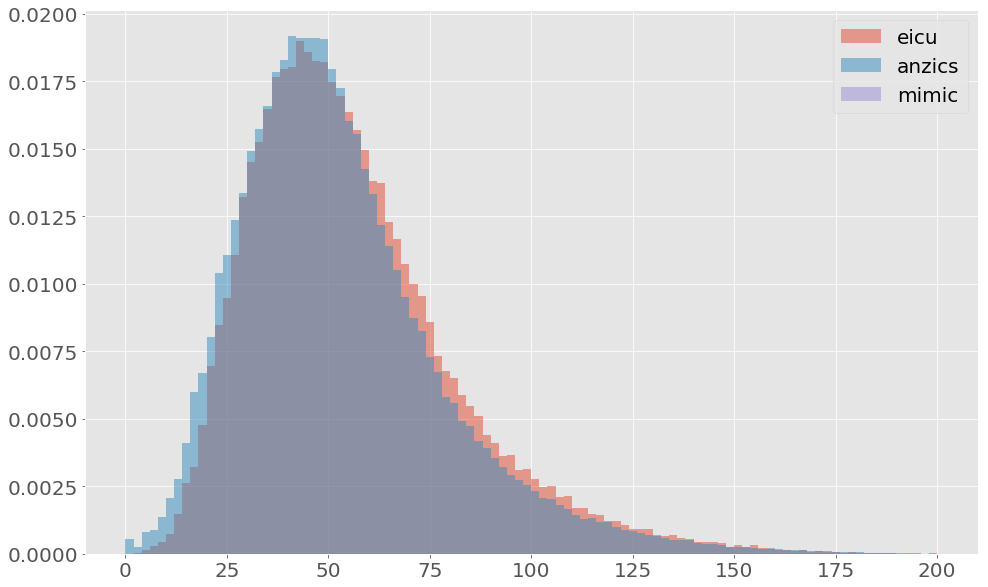

In [8]:
bins = np.linspace(0, 200, 101)
plt.figure(figsize=[16,10])
plt.rcParams.update({'font.size': 20})
plt.hist(df.loc[df['data_source']=='eicu','apache_3j_score'].dropna().values, bins,
         normed=True, alpha=0.5, label='eicu')
plt.hist(df.loc[df['data_source']=='anzics','apache_3j_score'].dropna().values, bins,
         normed=True, alpha=0.5, label='anzics')
plt.hist(df.loc[df['data_source']=='mimic','apache_3j_score'].dropna().values, bins,
         normed=True, alpha=0.5, label='mimic')
plt.legend(loc='upper right')
plt.show()

Note that we don't have any data for MIMIC for the APACHE-III score.

# Create histograms of variables

In [55]:
cont_demo=df_var.loc[(df_var['dataType']=='numeric')&(df_var['category']=='demographic'),'varname']
cont_demo=cont_demo.tolist()+['bmi']
cont_apache = df_var.loc[(df_var['category']=='APACHE covariate')&(df_var['dataType']=='numeric'),'varname'].tolist()
cont_vitals = df_var.loc[df_var['category']=='vitals','varname'].tolist()
labs=df_var.loc[df_var['category']=='labs','varname']
labs_bg=df_var.loc[df_var['category']=='labs blood gas','varname']
cont_labs=labs.tolist()+labs_bg.tolist()

cont = cont_demo + cont_apache + cont_vitals + cont_labs

tb_header = ['anzics','eicu','mimic','orchestra']
d = {}

for c in cont:
    totals=counting(c)
    if sum(x==0 for x in totals) > 2:
        continue
    idx = df['hospital_death'] < 2
    d,[avg_a,avg_e,avg_m,avg_o] = stats(d, c, idx)
    
    # create a histogram of the data
    plt.figure(figsize=[16,10])
    plt.rcParams.update({'font.size': 20})
    bins = np.linspace( df.loc[:,c].dropna().quantile(0.01), df.loc[:,c].dropna().quantile(0.99), 51 )
    
    if avg_e is np.nan:
        # no data
        binned_e = [0,0]
        bins_e = [0,0]
        lbl_e = 'eicu (no data)'
        plt.plot(binned_e, bins_e, 'o', label=lbl_e)
    else:
        lbl_e = 'eicu'
        binned_e,bins_e,patches_e = plt.hist(df.loc[df['data_source']=='eicu',c].dropna().values,
                                                      bins=bins, histtype='bar',normed=True, lw=2, alpha=0.5,
                                                      label=lbl_e)
        
    if avg_a is np.nan:
        # no data
        binned_a = [0,0]
        bins_a = [0,0]
        lbl_a = 'anzics (no data)'
        plt.plot(binned_a, bins_a, 'o', label=lbl_a)
    else:
        lbl_a = 'anzics'
        binned_a,bins_a,patches_a = plt.hist(df.loc[df['data_source']=='anzics',c].dropna().values,
                                             bins=bins, histtype='bar',normed=True, lw=2, alpha=0.5,
                                             label=lbl_a) 
    if avg_m is np.nan:
        # no data
        binned_m = [0,0]
        bins_m = [0,0]
        lbl_m = 'mimic (no data)'
        plt.plot(binned_m, bins_m, 'o', label=lbl_m)
    else:
        lbl_m = 'mimic'
        binned_m,bins_m,patches_m = plt.hist(df.loc[df['data_source']=='mimic',c].dropna().values,
                                             bins=bins, histtype='bar',normed=True, lw=2, alpha=0.5,
                                             label=lbl_m)
    if avg_o is np.nan:
        # no data
        binned_o = [0,0]
        bins_o = [0,0]
        lbl_o = 'orchestra (no data)'
        plt.plot(binned_o, bins_o, 'o', label=lbl_o)
    else:
        lbl_o = 'orchestra'
        binned_o,bins_o,patches_o = plt.hist(df.loc[df['data_source']=='orchestra',c].dropna().values,
                                             bins=bins, histtype='bar',normed=True, lw=2, alpha=0.5,
                                             label=lbl_o)
    plt.legend(loc='upper right')
    plt.savefig(os.path.join('results','hist',c+'.png'))
    plt.close()
    
    # just plot a line plot of the data
    plt.figure(figsize=[16,10])
    plt.rcParams.update({'font.size': 20})
    plt.plot(bins_e[0:-1] + (bins_e[1]-bins_e[0])/2.0, medfilt(binned_e,3), '-', lw=2, alpha=0.5, label=lbl_e, color='black')
    plt.plot(bins_a[0:-1] + (bins_a[1]-bins_a[0])/2.0, medfilt(binned_a,3), '-', lw=2, alpha=0.5, label=lbl_a, color = 'green') 
    plt.plot(bins_m[0:-1] + (bins_m[1]-bins_m[0])/2.0, medfilt(binned_m,3), '-', lw=2, alpha=0.5, label=lbl_m, color = 'red')
    plt.plot(bins_o[0:-1] + (bins_o[1]-bins_o[0])/2.0, medfilt(binned_o,3), '-', lw=2, alpha=0.5, label=lbl_o, color = 'blue')
    plt.legend(loc='upper right')
    plt.savefig(os.path.join('results',c+'.png'))
    plt.close()

print('done')

C:\Python27\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Python27\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\Python27\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Python27\lib\site-packages\numpy\core\_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
C:\Python27\lib\site-packages\numpy\core\_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Python27\lib\site-packages\numpy\core\_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(r

done


# Completion table

In [82]:
totals=[float(i) for i in counting('data_source')]
index = list(df_var['category'].astype('category').cat.categories)
category_gp=df_var.groupby('category')
header=['anzics','eicu','mimic','orchestra']
for i in index:
    display(HTML('<h2>'+i+'</h2>'))
    comp_dict={}
    for column in df_var.loc[df_var['category']==i,'varname']:
        if column == 'data_source':
            continue
        comp_dict[column]=np.divide(counting(column),totals)
    tb = pd.DataFrame(comp_dict, index=header)
    tb = tb.replace(to_replace=float(0), value='')
    tb=tb.transpose()
    display(HTML(tb.to_html()))

,anzics,eicu,mimic,orchestra
albumin_apache,0.936442,0.390091,0.365906,
arf_apache,0.999357,1,,
bilirubin_apache,0.899022,0.351901,0.44887,
bun_apache,0.957723,0.798286,0.993855,
creatinine_apache,0.961651,0.802317,0.99404,
fio2_apache,0.711205,0.241378,0.364283,
gcs_eyes_apache,0.964151,0.989197,0.994862,
gcs_motor_apache,0.964222,0.989197,0.990917,
gcs_unable_apache,,1,0.996753,
gcs_verbal_apache,0.963936,0.989197,0.991204,


,anzics,eicu,mimic,orchestra
apache_3j_hospital_death_prob,0.992787,,,
apache_3j_score,0.994501,1,,
apache_4a_hospital_death_prob,,1,,
apache_4a_icu_death_prob,,1,,


,anzics,eicu,mimic,orchestra
age,1,0.965273,1,1
bmi,0.337999,0.964352,0.396506,0.580571
country,1,1,1,1
elective_surgery,0.996929,0.201875,1,1
ethnicity,0.0697708,0.988107,1,
gender,0.999929,0.999754,1,0.999849
height,0.340641,0.987976,0.397801,0.586585
hospital_admit_source,0.934086,0.752856,1,
hospital_bed_size,,0.88626,,1
hospital_death,0.998143,1,1,1


,anzics,eicu,mimic,orchestra
encounter_id,1.0,1.0,1.0,1.0
hospital_id,1.0,1.0,1.0,1.0
patient_id,1.0,1.0,1.0,1.0


,anzics,eicu,mimic,orchestra
d1_albumin_max,,0.446063,0.289211,
d1_albumin_min,,0.446063,0.289211,
d1_bilirubin_max,,0.403274,0.359782,
d1_bilirubin_min,,0.403274,0.359782,
d1_bun_max,,0.895404,0.981628,
d1_bun_min,,0.895404,0.981628,
d1_calcium_max,,0.871718,0.838512,
d1_calcium_min,,0.871718,0.838512,
d1_creatinine_max,0.945226,0.89902,0.981977,
d1_creatinine_min,0.875455,0.89902,0.981977,


,anzics,eicu,mimic,orchestra
d1_arterial_pco2_max,,0.366612,0.548397,
d1_arterial_pco2_min,,0.366612,0.548397,
d1_arterial_ph_max,,0.359333,0.548376,
d1_arterial_ph_min,,0.359333,0.548376,
d1_arterial_po2_max,,0.366842,0.548418,
d1_arterial_po2_min,,0.366842,0.548418,
d1_pao2fio2ratio_max,,,0.426716,
d1_pao2fio2ratio_min,,0.267943,0.426716,
h1_arterial_pco2_max,,0.17597,0.290691,0.374064
h1_arterial_pco2_min,,0.17597,0.290691,0.116295


,anzics,eicu,mimic,orchestra
d1_diasbp_invasive_max,,0.253854,0.46457,
d1_diasbp_invasive_min,,0.253854,0.46457,
d1_diasbp_max,0.950011,0.990003,0.996938,
d1_diasbp_min,0.931443,0.990003,0.996938,
d1_diasbp_noninvasive_max,,0.969895,0.88136,
d1_diasbp_noninvasive_min,,0.969895,0.88136,
d1_heartrate_max,0.967935,0.990264,0.997657,
d1_heartrate_min,0.943941,0.990264,0.997657,
d1_mbp_invasive_max,,0.255451,0.472832,
d1_mbp_invasive_min,,0.255451,0.472832,


# Ventilated vs Not

In [60]:
tb_header = ['anzics','eicu','mimic','orchestra']
d = {}
cont = ['h1_arterial_po2_min', 'h1_arterial_po2_max', 'd1_arterial_po2_min', 'd1_arterial_po2_max','pao2_apache']
if not os.path.exists(os.path.join('results','po2')):
    os.makedirs(os.path.join('results','po2'))
for c in cont:
    for i in (0,1):
        idx = df['ventilated_apache'] == i
        d,[avg_a,avg_e,avg_m,avg_o] = stats(d, c, idx)

        # create a histogram of the data
        plt.figure(figsize=[16,10])
        plt.rcParams.update({'font.size': 20})
        bins = np.linspace( df.loc[:,c].dropna().quantile(0.01), df.loc[:,c].dropna().quantile(0.99), 51 )

        if avg_e is np.nan:
            # no data
            binned_e = [0,0]
            bins_e = [0,0]
            lbl_e = 'eicu (no data)'
            plt.plot(binned_e, bins_e, 'o', label=lbl_e)
        else:
            count = (df.loc[((df['data_source']=='eicu')&(df['ventilated_apache']==i)),c].count()+0.0)
            proportion = count/(df['data_source']=='eicu').sum()*100
            
            proportion_gp = count/((df['data_source']=='eicu')&(df['ventilated_apache']==i)).sum()*100
            if np.isnan(proportion_gp):
                lbl_e = 'eicu'+ ' ('+"%d" % proportion + '% DB)'
            else:
                lbl_e = 'eicu'+ ' ('+"%d" % proportion + '% DB) ('+"%d" % proportion_gp + '% group)'
            binned_e,bins_e,patches_e = plt.hist(df.loc[((df['data_source']=='eicu')&(df['ventilated_apache']==i)),c].dropna().values,
                                                          bins=bins, histtype='bar',normed=True, lw=2, alpha=0.5,
                                                          label=lbl_e)

        if avg_a is np.nan:
            # no data
            binned_a = [0,0]
            bins_a = [0,0]
            lbl_a = 'anzics (no data)'
            plt.plot(binned_a, bins_a, 'o', label=lbl_a)
        else:
            count = (df.loc[((df['data_source']=='anzics')&(df['ventilated_apache']==i)),c].count()+0.0)
            proportion = count/(df['data_source']=='anzics').sum()*100
            proportion_gp = count/((df['data_source']=='anzics')&(df['ventilated_apache']==i)).sum()*100
            if np.isnan(proportion_gp):
                lbl_a = 'anzics'+ ' ('+"%d" % proportion + '% DB)'
            else:
                lbl_a = 'anzics'+ ' ('+"%d" % proportion + '% DB) ('+"%d" % proportion_gp + '% group)'
            binned_a,bins_a,patches_a = plt.hist(df.loc[((df['data_source']=='anzics')&(df['ventilated_apache']==i)),c].dropna().values,
                                                 bins=bins, histtype='bar',normed=True, lw=2, alpha=0.5,
                                                 label=lbl_a) 
        if avg_m is np.nan:
            # no data
            binned_m = [0,0]
            bins_m = [0,0]
            lbl_m = 'mimic (no data)'
            plt.plot(binned_m, bins_m, 'o', label=lbl_m)
        else:
            count = (df.loc[((df['data_source']=='mimic')&(df['ventilated_apache']==i)),c].count()+0.0)
            proportion = count/(df['data_source']=='mimic').sum()*100
            proportion_gp = count/((df['data_source']=='mimic')&(df['ventilated_apache']==i)).sum()*100
            if np.isnan(proportion_gp):
                lbl_m = 'mimic'+ ' ('+"%d" % proportion + '% DB)'
            else:
                lbl_m = 'mimic'+ ' ('+"%d" % proportion + '% DB) ('+"%d" % proportion_gp + '% group)'
            binned_m,bins_m,patches_m = plt.hist(df.loc[((df['data_source']=='mimic')&(df['ventilated_apache']==i)),c].dropna().values,
                                                 bins=bins, histtype='bar',normed=True, lw=2, alpha=0.5,
                                                 label=lbl_m)
        if avg_o is np.nan:
            # no data
            binned_o = [0,0]
            bins_o = [0,0]
            lbl_o = 'orchestra (no data)'
            plt.plot(binned_o, bins_o, 'o', label=lbl_o)
        else:
            count = (df.loc[((df['data_source']=='orchestra')&(df['ventilated_apache']==i)),c].count()+0.0)
            proportion = count/(df['data_source']=='orchestra').sum()*100
            proportion_gp = count/((df['data_source']=='orchestra')&(df['ventilated_apache']==i)).sum()*100
            if np.isnan(proportion_gp):
                lbl_o = 'orchestra'+ ' ('+"%d" % proportion + '% DB)'
            else:
                lbl_o = 'orchestra'+ ' ('+"%d" % proportion + '% DB) ('+"%d" % proportion_gp + '% group)'
            binned_o,bins_o,patches_o = plt.hist(df.loc[((df['data_source']=='orchestra')&(df['ventilated_apache']==i)),c].dropna().values,
                                                 bins=bins, histtype='bar',normed=True, lw=2, alpha=0.5,
                                                 label=lbl_o)
        plt.legend(loc='upper right')
        if i==1:
            plt.title('Ventilated '+c)
            plt.savefig(os.path.join('results','po2','his_V'+c+'.png'))
        else:
            plt.title('Not Ventilated '+c)
            plt.savefig(os.path.join('results','po2','his_'+c+'.png'))
        plt.close()

        # just plot a line plot of the data
        plt.figure(figsize=[16,10])
        plt.rcParams.update({'font.size': 20})
        plt.plot(bins_e[0:-1] + (bins_e[1]-bins_e[0])/2.0, medfilt(binned_e,3), '-', lw=2, alpha=0.5, label=lbl_e, color='black')
        plt.plot(bins_a[0:-1] + (bins_a[1]-bins_a[0])/2.0, medfilt(binned_a,3), '-', lw=2, alpha=0.5, label=lbl_a, color = 'green') 
        plt.plot(bins_m[0:-1] + (bins_m[1]-bins_m[0])/2.0, medfilt(binned_m,3), '-', lw=2, alpha=0.5, label=lbl_m, color = 'red')
        plt.plot(bins_o[0:-1] + (bins_o[1]-bins_o[0])/2.0, medfilt(binned_o,3), '-', lw=2, alpha=0.5, label=lbl_o, color = 'blue')
        plt.legend(loc='upper right')
        if i==1:
            plt.title('Ventilated '+c)
            plt.savefig(os.path.join('results','po2','V_'+c+'.png'))
        else:
            plt.title('Not Ventilated '+c)
            plt.savefig(os.path.join('results','po2',c+'.png'))
        plt.close()


C:\Python27\lib\site-packages\ipykernel\__main__.py:78: RuntimeWarning: invalid value encountered in double_scalars


# Compare Hospital Death vs No Hospital Death

In [62]:
fac_list = df_var.loc[(df_var['dataType']!='numeric')&(df_var['category']!='identifier'),'varname']
for a in fac_list:
    if a in ['hospital_death','bmi','apache_3j_score','icu_id']:
        continue
    tbl = pd.crosstab(df[a], [df['hospital_death'],df['data_source']], margins = True)
    display(HTML(tbl.to_html().replace('NaN', '')))
    #get percentage table
    tbl_perc = tbl/tbl.xs('All', axis=0)
    display(HTML(tbl_perc.to_html()))

hospital_death,0.0,1.0,All
data_source,anzics,anzics,
hospital_type,,,
Metropolitan,1576,376,1952
Private,3133,377,3510
Rural / Regional,980,207,1187
Tertiary,6112,1216,7328
All,11801,2176,13977


hospital_death,0.0,1.0,All
data_source,anzics,anzics,
hospital_type,,,
Metropolitan,0.133548,0.172794,0.139658
Private,0.265486,0.173254,0.251127
Rural / Regional,0.083044,0.095129,0.084925
Tertiary,0.517922,0.558824,0.524290
All,1.000000,1.000000,1.000000


In [64]:
i=0
sub_cont = [cont_demo, cont_apache, cont_vitals, cont_labs]
sb_header = ['Demographics', 'APACHE', 'Vitals', 'Labs']

for sb in sub_cont:
    d_alive = {}
    d_death = {}
    
    display(HTML('<h2>'+sb_header[i]+'</h2>'))
    i=i+1
    for s in sb:
        totals=counting(s)
        if sum(x==0 for x in totals) > 2:
            continue
        idx = df['hospital_death']==0
        d_alive, trash = stats(d_alive, s, idx)
        idx = df['hospital_death']==1
        d_death, trash = stats(d_death, s, idx) 
    tb = pd.DataFrame(d_alive, index=tb_header)
    tb=tb.transpose()

    tb_d = pd.DataFrame(d_death, index=tb_header)
    tb_d=tb_d.transpose()

    tb_concat=pd.concat([tb,tb_d], axis=1, keys=['No Hospital Death','Hospital Death'])
    display(HTML(tb_concat.to_html().replace('NaN', '')))

# All patients table

In [12]:
tb = pd.DataFrame(d, index=tb_header)
tb=tb.transpose()
display(HTML(tb.to_html().replace('NaN', '')))

,anzics,eicu,mimic,orchestra
age_avg,60.420791,62.078115,74.834305,62.331245
age_med,64.400000,64.000000,65.688000,65.000000
age_std,19.391007,16.577414,55.151000,19.327434
albumin_apache_avg,3.005180,2.895859,3.205178,
albumin_apache_med,3.000000,2.900000,3.200000,
albumin_apache_std,0.641370,0.690841,0.733821,
apache_3j_score_avg,52.635810,55.499781,,
apache_3j_score_med,48.000000,51.000000,,
apache_3j_score_std,25.487398,25.595483,,
arf_apache_avg,0.047336,0.036623,,


In [13]:
tb.to_csv('gossis-stats.csv',index=True)

# Day 1 vs Hour 1

In [15]:
d1_h1=['arterial_pco2_max', 'arterial_pco2_min', 'arterial_ph_max', 'arterial_ph_min', 'arterial_po2_max', 'arterial_po2_min', 
       'bilirubin_max', 'creatinine_max', 'diasbp_min', 'heartrate_max', 'lactate_max', 'mbp_min', 'pao2fio2ratio_max', 
       'pao2fio2ratio_min', 'platelets_min', 'resprate_max', 'sysbp_min', 'temp_max', 'wbc_max', 'mbp_invasive_max', 
       'mbp_invasive_min','mbp_noninvasive_max','mbp_noninvasive_min']
if not os.path.exists(os.path.join('results','d1_h1')):
    os.makedirs(os.path.join('results','d1_h1'))
for dh in d1_h1:
    # just plot a line plot of the data
    plt.figure(figsize=[16,10])
    plt.hist(df.loc[df['data_source']=='mimic','d1_'+dh].dropna().values,
             normed=True, alpha=0.5, label='mimic_d1')
    plt.hist(df.loc[df['data_source']=='eicu','d1_'+dh].dropna().values, bins,
             normed=True, alpha=0.5, label='eicu_d1')
    plt.hist(df.loc[df['data_source']=='mimic','h1_'+dh].dropna().values, bins,
             normed=True, alpha=0.5, label='mimic_h1')
    plt.hist(df.loc[df['data_source']=='eicu','h1_'+dh].dropna().values, bins,
             normed=True, alpha=0.5, label='eicu_h1')
    plt.legend(loc='upper right')
    plt.savefig(os.path.join('results','d1_h1',dh+'.png'))
    plt.close()
    
header = ['eicu_d1','eicu_h1','mimic_d1','mimic_h1', 'orchestra']
hd = {}

for dh in d1_h1:
    avg_a = np.mean(df.loc[(df['data_source']=='eicu'),'d1_'+dh].dropna().values)
    avg_e = np.mean(df.loc[(df['data_source']=='eicu'),'h1_'+dh].dropna().values)
    avg_m = np.mean(df.loc[(df['data_source']=='mimic'),'d1_'+dh].dropna().values)
    avg_o = np.mean(df.loc[(df['data_source']=='mimic'),'h1_'+dh].dropna().values)
    avg_t = np.mean(df.loc[(df['data_source']=='orchestra'),'h1_'+dh].dropna().values)
    hd[dh+'_avg']= [avg_a, avg_e, avg_m, avg_o, avg_t]
    std_a = np.std(df.loc[(df['data_source']=='eicu'),'d1_'+dh].dropna().values)
    std_e = np.std(df.loc[(df['data_source']=='eicu'),'h1_'+dh].dropna().values)
    std_m = np.std(df.loc[(df['data_source']=='mimic'),'d1_'+dh].dropna().values)
    std_o = np.std(df.loc[(df['data_source']=='mimic'),'h1_'+dh].dropna().values)
    std_t = np.std(df.loc[(df['data_source']=='orchestra'),'h1_'+dh].dropna().values)
    hd[dh+'_std']= [std_a, std_e, std_m, std_o, std_t]
    med_a = np.median(df.loc[(df['data_source']=='eicu'),'d1_'+dh].dropna().values)
    med_e = np.median(df.loc[(df['data_source']=='eicu'),'h1_'+dh].dropna().values)
    med_m = np.median(df.loc[(df['data_source']=='mimic'),'d1_'+dh].dropna().values)
    med_o = np.median(df.loc[(df['data_source']=='mimic'),'h1_'+dh].dropna().values)
    med_t = np.median(df.loc[(df['data_source']=='orchestra'),'h1_'+dh].dropna().values)
    hd[dh+'_med']= [med_a, med_e, med_m, med_o, med_t]
    
    # create a histogram of the data
    plt.figure(figsize=[16,10])
    plt.rcParams.update({'font.size': 20})
    bins = np.linspace( df.loc[:,'h1_'+dh].dropna().quantile(0.01), df.loc[:,'h1_'+dh].dropna().quantile(0.99), 51 )
    
    if avg_a is np.nan:
        # no data
        binned_a = [0,0]
        bins_a = [0,0]
        lbl_a = 'eicu_d1 (no data)'
        plt.plot(binned_a, bins_a, 'o', label=lbl_a)
    else:
        proportion = (df.loc[df['data_source']=='eicu','d1_'+dh].count()+0.0)/(df['data_source']=='eicu').sum()*100
        lbl_a = 'eicu_d1' + ' ('+"%d" % proportion + '%)'
        binned_a,bins_a,patches_a = plt.hist(df.loc[df['data_source']=='eicu','d1_'+dh].dropna().values,
                                             bins=bins, histtype='bar',normed=True, lw=2, alpha=0.5,
                                             label=lbl_a) 
    if avg_e is np.nan:
        # no data
        binned_e = [0,0]
        bins_e = [0,0]
        lbl_e = 'eicu_h1 (no data)'
        plt.plot(binned_e, bins_e, 'o', label=lbl_e)
    else:
        proportion = (df.loc[df['data_source']=='eicu','h1_'+dh].count()+0.0)/(df['data_source']=='eicu').sum()*100
        lbl_e = 'eicu_h1'+ ' ('+"%d" % proportion + '%)'
        binned_e,bins_e,patches_e = plt.hist(df.loc[df['data_source']=='eicu','h1_'+dh].dropna().values,
                                                      bins=bins, histtype='bar',normed=True, lw=2, alpha=0.5,
                                                      label=lbl_e)
    if avg_m is np.nan:
        # no data
        binned_m = [0,0]
        bins_m = [0,0]
        lbl_m = 'mimic_d1 (no data)'
        plt.plot(binned_m, bins_m, 'o', label=lbl_m)
    else:
        proportion = (df.loc[df['data_source']=='mimic','d1_'+dh].count()+0.0)/(df['data_source']=='mimic').sum()*100
        lbl_m = 'mimic_d1' + ' ('+"%d" % proportion + '%)'
        binned_m,bins_m,patches_m = plt.hist(df.loc[df['data_source']=='mimic','d1_'+dh].dropna().values,
                                             bins=bins, histtype='bar',normed=True, lw=2, alpha=0.5,
                                             label=lbl_m)
    if avg_o is np.nan:
        # no data
        binned_o = [0,0]
        bins_o = [0,0]
        lbl_o = 'mimic_h1 (no data)'
        plt.plot(binned_o, bins_o, 'o', label=lbl_o)
    else:
        proportion = (df.loc[df['data_source']=='mimic','h1_'+dh].count()+0.0)/(df['data_source']=='mimic').sum()*100
        lbl_o = 'mimic_h1' + ' ('+"%d" % proportion + '%)'
        binned_o,bins_o,patches_o = plt.hist(df.loc[df['data_source']=='mimic','h1_'+dh].dropna().values,
                                             bins=bins, histtype='bar',normed=True, lw=2, alpha=0.5,
                                             label=lbl_o)
    if avg_t is np.nan:
        # no data
        binned_t = [0,0]
        bins_t = [0,0]
        lbl_t = 'orchestra_h1 (no data)'
        plt.plot(binned_t, bins_t, 'o', label=lbl_t)
    else:
        proportion = (df.loc[df['data_source']=='orchestra','h1_'+dh].count()+0.0)/(df['data_source']=='orchestra').sum()*100
        lbl_t = 'orchestra_h1' + ' ('+"%d" % proportion + '%)'
        binned_t,bins_t,patches_t = plt.hist(df.loc[df['data_source']=='orchestra','h1_'+dh].dropna().values,
                                             bins=bins, histtype='bar',normed=True, lw=2, alpha=0.5,
                                             label=lbl_t)
    plt.legend(loc='upper right')
    plt.savefig(os.path.join('results','d1_h1',dh+'_his.png'))
    plt.close()
    
    # just plot a line plot of the data
    plt.figure(figsize=[16,10])
    plt.rcParams.update({'font.size': 20})    
    plt.plot(bins_a[0:-1] + (bins_a[1]-bins_a[0])/2.0, medfilt(binned_a,3), '-', lw=2, alpha=0.5, label=lbl_a)
    plt.plot(bins_e[0:-1] + (bins_e[1]-bins_e[0])/2.0, medfilt(binned_e,3), '-', lw=2, alpha=0.5, label=lbl_e)
    plt.plot(bins_m[0:-1] + (bins_m[1]-bins_m[0])/2.0, medfilt(binned_m,3), '-', lw=2, alpha=0.5, label=lbl_m)
    plt.plot(bins_o[0:-1] + (bins_o[1]-bins_o[0])/2.0, medfilt(binned_o,3), '-', lw=2, alpha=0.5, label=lbl_o)
    plt.plot(bins_t[0:-1] + (bins_t[1]-bins_t[0])/2.0, medfilt(binned_t,3), '-', lw=2, alpha=0.5, label=lbl_t)
    plt.legend(loc='upper right')
    plt.savefig(os.path.join('results','d1_h1',dh+'.png'))
    plt.close()
    
tb = pd.DataFrame(hd, index=header)
tb=tb.transpose()
display(HTML(tb.to_html().replace('NaN', '')))

,eicu_d1,eicu_h1,mimic_d1,mimic_h1,orchestra
arterial_pco2_max_avg,46.152422,45.422928,47.136818,44.441357,38.603498
arterial_pco2_max_med,43.000000,42.800000,45.000000,42.000000,37.000000
arterial_pco2_max_std,15.789478,15.773714,13.406921,12.570400,12.475641
arterial_pco2_min_avg,39.205648,44.205406,36.744201,41.751573,36.318192
arterial_pco2_min_med,37.400000,41.000000,35.000000,40.000000,35.250000
arterial_pco2_min_std,11.968608,15.260450,9.496664,12.069895,11.647419
arterial_ph_max_avg,7.403963,7.335933,7.420357,7.374794,7.377198
arterial_ph_max_med,7.390000,7.350000,7.420000,7.390000,7.390000
arterial_ph_max_std,3.349738,0.112533,0.073063,0.098529,0.092652
arterial_ph_min_avg,7.338759,7.325845,7.325160,7.350263,7.348691


# About Databases (Demographics)

In [83]:
databases = ['anzics', 'eicu', 'mimic', 'orchestra']
for db in databases:
    display(HTML('<h2>'+db+'</h2>'))
    fac_list = ['elective_surgery','gender','icu_death','pregnant','readmission_status']

    dem_tb={}
    header = {0.0:'0 (gender = M)', 1.0:'1 (gender = F)'}
    for a in fac_list:
        tbl = df.loc[df['data_source']==db,a].dropna().value_counts()
        if a=='gender':
            tbl=[tbl['M'],tbl['F']]
        dem_tb[a]=tbl
        dem_tb[a+' (%)']=tbl/(sum(tbl)+0.0)

    tb = pd.DataFrame(dem_tb).transpose()
    tb.rename(columns=header, inplace=True)
    display(HTML(tb.to_html().replace('NaN', '')))
    tb.to_csv('table_bin_demo_'+db+'.csv')

    fac_list = ['smoking_status','ethnicity','hospital_admit_source','hospital_disch_location','icu_admit_source',
               'icu_admit_type','icu_disch_location','icu_stay_type','icu_type','hospital_bed_size']

    for a in fac_list:
        dem_tb={}
        tbl = df.loc[df['data_source']==db,a].dropna().value_counts()
        dem_tb[a]=tbl
        dem_tb[a+' (%)']=tbl/(sum(tbl)+0.0)

        tb = pd.DataFrame(dem_tb).transpose()
        display(HTML(tb.to_html().replace('NaN', '')))
    
    hd= {}
    header = ['Median','Average', 'Standard Dev']
    cont_fac=['age','bmi','height','icu_los_days','pre_icu_los_days','weight']
    for a in cont_fac:
        avg = np.mean(df.loc[(df['data_source']==db),a].dropna().values)
        std = np.std(df.loc[(df['data_source']==db),a].dropna().values)
        med = np.median(df.loc[(df['data_source']==db),a].dropna().values)
        hd[a]= [med, avg, std]
    tb = pd.DataFrame(hd, index=header).transpose()
    display(HTML(tb.to_html().replace('NaN', '')))
    tb.to_csv('cont_demo_'+db+'.csv')
    

,0 (gender = M),1 (gender = F)
elective_surgery,10541.000000,3419.000000
elective_surgery (%),0.755086,0.244914
gender,8293.000000,5709.000000
gender (%),0.592273,0.407727
icu_death,12889.000000,1068.000000
icu_death (%),0.923479,0.076521
pregnant,1826.000000,13.000000
pregnant (%),0.992931,0.007069
readmission_status,,14003.000000
readmission_status (%),,1.000000


,Ex-Smoker,Never Smoked,Current Smoker
smoking_status,1837.000000,1394.000000,783.000000
smoking_status (%),0.457648,0.347285,0.195067


,Indigenous
ethnicity,977.0
ethnicity (%),1.0


,Home,Other Acute Hospital,Other hospital ICU,Chronic Care Hospital (including nursing homes)
hospital_admit_source,10114.000000,2742.000000,115.000000,109.000000
hospital_admit_source (%),0.773242,0.209633,0.008792,0.008333


,Discharged home,Transferred to Chronic Care/Rehabilitation Hospital,Died in Hospital,Transferred to Other Acute Care Hospital,Transferred to Other Hospital ICU
hospital_disch_location,7485.000000,2247.000000,2176.000000,1942.000000,127.000000
hospital_disch_location (%),0.535523,0.160764,0.155684,0.138943,0.009086


,Ward,OT/Recovery,Accident & Emergency,"Other ICU, same Hospital",Other Hospital,Other Hospital ICU
icu_admit_source,9104.000000,4599.000000,161.000000,88.000000,21.000000,8.000000
icu_admit_source (%),0.651169,0.328946,0.011516,0.006294,0.001502,0.000572


""
icu_admit_type
icu_admit_type (%)


,Survived ICU,Died in ICU,Transferred to another ICU,Transferred to another hospital
icu_disch_location,12472.000000,1068.000000,210.000000,207.000000
icu_disch_location (%),0.893602,0.076521,0.015046,0.014831


,ICU,HDU
icu_stay_type,10539.000000,3448.000000
icu_stay_type (%),0.753485,0.246515


""
icu_type
icu_type (%)


""
hospital_bed_size
hospital_bed_size (%)


,Median,Average,Standard Dev
age,67.000000,63.895274,16.176067
bmi,26.861207,29.207659,38.664301
height,170.000000,169.092243,11.626683
icu_los_days,2.576389,4.532882,7.175702
pre_icu_los_days,10.524653,18.695440,45.235103
weight,78.000000,80.796233,22.750409


,0 (gender = M),1 (gender = F)
elective_surgery,2859.000000,23434.000000
elective_surgery (%),0.108736,0.891264
gender,70505.000000,59707.000000
gender (%),0.541463,0.458537
icu_death,122714.000000,7521.000000
icu_death (%),0.942251,0.057749
pregnant,,
pregnant (%),,
readmission_status,130244.000000,
readmission_status (%),1.000000,


""
smoking_status
smoking_status (%)


,Caucasian,African American,Other/Unknown,Hispanic,Asian,Native American
ethnicity,99750.000000,15743.000000,5822.000000,4715.000000,1660.000000,1005.000000
ethnicity (%),0.775088,0.122328,0.045239,0.036637,0.012899,0.007809


,Emergency Department,Operating Room,Floor,Direct Admit,Recovery Room,Other Hospital,Acute Care/Floor,Step-Down Unit (SDU),PACU,Other ICU,Chest Pain Center,ICU to SDU,ICU,Observation,Other
hospital_admit_source,52226.000000,12829.000000,11354.000000,8972.0000,4399.000000,2660.000000,2258.000000,1603.000000,1064.000000,285.000000,282.000000,62.000000,42.000000,12.000000,7.000000
hospital_admit_source (%),0.532619,0.130835,0.115792,0.0915,0.044863,0.027128,0.023028,0.016348,0.010851,0.002907,0.002876,0.000632,0.000428,0.000122,0.000071


,Home,Skilled Nursing Facility,Death,Rehabilitation,Other External,Other,Other Hospital,Nursing Home
hospital_disch_location,75561.00000,17716.000000,11943.000000,6595.000000,6342.000000,5817.000000,5304.000000,966.000000
hospital_disch_location (%),0.58015,0.136022,0.091697,0.050636,0.048693,0.044662,0.040724,0.007417


,Emergency Department,Operating Room,Floor,Direct Admit,Recovery Room,Acute Care/Floor,Step-Down Unit (SDU),Other Hospital,PACU,Other ICU,Chest Pain Center,ICU,ICU to SDU,Observation,Other
icu_admit_source,64224.000000,18739.000000,17253.000000,9950.000000,5794.000000,4249.000000,3910.000000,3405.000000,1393.000000,641.000000,308.000000,107.000000,97.000000,13.0000,8.000000
icu_admit_source (%),0.493685,0.144045,0.132623,0.076485,0.044538,0.032662,0.030056,0.026174,0.010708,0.004927,0.002368,0.000823,0.000746,0.0001,0.000061


,Med-Surg ICU,MICU,Neuro ICU,CCU-CTICU,SICU,Cardiac ICU,CTICU,CSICU
icu_admit_type,66756.000000,12862.000000,11429.000000,11277.000000,9690.000000,8376.00000,5296.000000,4558.000000
icu_admit_type (%),0.512546,0.098753,0.087751,0.086584,0.074399,0.06431,0.040662,0.034996


,Floor,Step-Down Unit (SDU),Acute Care/Floor,Home,Death,Telemetry,Other Hospital,Other External,Skilled Nursing Facility,Other,Other ICU,Rehabilitation,Other Internal,Nursing Home,ICU,Operating Room,Other ICU (CABG)
icu_disch_location,63959.000000,18113.0000,14283.000000,11603.000000,7521.000000,6403.000000,2658.000000,1944.000000,1318.000000,963.000000,562.000000,493.000000,199.000000,128.000000,57.000000,7.000000,5.000000
icu_disch_location (%),0.491176,0.1391,0.109687,0.089106,0.057758,0.049172,0.020412,0.014929,0.010122,0.007395,0.004316,0.003786,0.001528,0.000983,0.000438,0.000054,0.000038


,admit,readmit,transfer
icu_stay_type,116780.000000,7147.000000,6317.000000
icu_stay_type (%),0.896625,0.054874,0.048501


,Med-Surg ICU,MICU,Neuro ICU,CCU-CTICU,SICU,Cardiac ICU,CTICU,CSICU
icu_type,66756.000000,12862.000000,11429.000000,11277.000000,9690.000000,8376.00000,5296.000000,4558.000000
icu_type (%),0.512546,0.098753,0.087751,0.086584,0.074399,0.06431,0.040662,0.034996


,>= 500,100 - 249,250 - 499,<100
hospital_bed_size,56649.000000,27331.000000,25447.000000,6003.000000
hospital_bed_size (%),0.490765,0.236776,0.220454,0.052006


,Median,Average,Standard Dev
age,64.000000,62.099872,16.548143
bmi,27.580200,269.449564,9041.845325
height,170.100000,169.409650,13.791611
icu_los_days,1.820833,3.007480,4.009527
pre_icu_los_days,0.164583,1.360097,5.075604
weight,80.060000,84.135020,27.057620


,0 (gender = M),1 (gender = F)
elective_surgery,41730.000000,6930.000000
elective_surgery (%),0.857583,0.142417
gender,27344.000000,21316.000000
gender (%),0.561940,0.438060
icu_death,44903.000000,3757.000000
icu_death (%),0.922791,0.077209
pregnant,2684.000000,28.000000
pregnant (%),0.989676,0.010324
readmission_status,48580.000000,80.000000
readmission_status (%),0.998356,0.001644


,0.0,2.0,0.0,2.0
smoking_status,247.00000,79.000000,19.000000,3.000000
smoking_status (%),0.70977,0.227011,0.054598,0.008621


,Caucasian,Other/Unknown,African American,Hispanic,Asian,Native American
ethnicity,34828.000000,6288.000000,4649.00000,1741.000000,1129.000000,25.000000
ethnicity (%),0.715742,0.129223,0.09554,0.035779,0.023202,0.000514


,EMERGENCY ROOM ADMIT,CLINIC REFERRAL/PREMATURE,PHYS REFERRAL/NORMAL DELI,TRANSFER FROM HOSP/EXTRAM,TRANSFER FROM SKILLED NUR,TRANSFER FROM OTHER HEALT,TRSF WITHIN THIS FACILITY,** INFO NOT AVAILABLE **,HMO REFERRAL/SICK
hospital_admit_source,21963.000000,9744.000000,8443.00000,8176.000000,257.000000,68.000000,4.000000,4.000000,1.000000
hospital_admit_source (%),0.451356,0.200247,0.17351,0.168023,0.005282,0.001397,0.000082,0.000082,0.000021


,HOME,HOME HEALTH CARE,SNF,REHAB/DISTINCT PART HOSP,DEAD/EXPIRED,LONG TERM CARE HOSPITAL,DISC-TRAN CANCER/CHLDRN H,SHORT TERM HOSPITAL,DISCH-TRAN TO PSYCH HOSP,HOSPICE-HOME,LEFT AGAINST MEDICAL ADVI,HOSPICE-MEDICAL FACILITY,OTHER FACILITY,HOME WITH HOME IV PROVIDR,ICF,DISC-TRAN TO FEDERAL HC,SNF-MEDICAID ONLY CERTIF
hospital_disch_location,12572.000000,12140.000000,7442.000000,6247.000000,5443.000000,2264.000000,576.000000,474.000000,438.000000,397.000000,339.000000,152.000000,61.000000,60.000000,43.000000,11.000000,1.000000
hospital_disch_location (%),0.258364,0.249486,0.152939,0.128381,0.111858,0.046527,0.011837,0.009741,0.009001,0.008159,0.006967,0.003124,0.001254,0.001233,0.000884,0.000226,0.000021


""
icu_admit_source
icu_admit_source (%)


,EMERGENCY,ELECTIVE,URGENT
icu_admit_type,40521.000000,6930.000000,1209.000000
icu_admit_type (%),0.832737,0.142417,0.024846


,MICU,CSRU,SICU,CCU,TSICU
icu_disch_location,19441.000000,8610.000000,8220.000000,6794.000000,5595.000000
icu_disch_location (%),0.399527,0.176942,0.168927,0.139622,0.114982


,MED,CSURG,CMED,SURG,NSURG,TRAUM,NMED,TSURG,VSURG,ORTHO,OMED,GU,PSURG,ENT,GYN,OBS,DENT
icu_stay_type,19039.000000,6815.000000,5412.00000,3796.00000,3097.000000,2676.000000,2137.000000,950.000000,797.000000,502.000000,390.000000,236.0000,143.00000,135.000000,127.000000,19.000000,5.000000
icu_stay_type (%),0.411423,0.147269,0.11695,0.08203,0.066925,0.057827,0.046179,0.020529,0.017223,0.010848,0.008428,0.0051,0.00309,0.002917,0.002744,0.000411,0.000108


,MICU,CSRU,SICU,CCU,TSICU
icu_type,19279.000000,8505.000000,7923.000000,7094.000000,5859.000000
icu_type (%),0.396198,0.174784,0.162824,0.145787,0.120407


""
hospital_bed_size
hospital_bed_size (%)


,Median,Average,Standard Dev
age,65.688000,74.834305,55.151000
bmi,27.623134,29.116205,10.668251
height,170.180000,169.366664,11.953668
icu_los_days,2.134500,4.107559,6.015043
pre_icu_los_days,0.000000,1.041143,3.331449
weight,78.100000,81.213152,23.170990


,0 (gender = M),1 (gender = F)
elective_surgery,43041.000000,16652.000000
elective_surgery (%),0.721039,0.278961
gender,29773.000000,29911.000000
gender (%),0.498844,0.501156
icu_death,53970.000000,5722.000000
icu_death (%),0.904141,0.095859
pregnant,,
pregnant (%),,
readmission_status,59693.000000,
readmission_status (%),1.000000,


""
smoking_status
smoking_status (%)


""
ethnicity
ethnicity (%)


""
hospital_admit_source
hospital_admit_source (%)


,Transferred to Chronic Care/Rehabilitation Hospital,Died in Hospital,Transferred to Other Acute Care Hospital,Discharged home,Transferred to Other Hospital ICU
hospital_disch_location,47449.000000,8228.000000,927.000000,354.000000,21.000000
hospital_disch_location (%),0.832745,0.144404,0.016269,0.006213,0.000369


,Accident & Emergency,OT/Recovery,Ward,Other Hospital,Intervention room,"Other ICU, same Hospital",Intermediate care unit,Other unkown,Home-care
icu_admit_source,31348.000000,17319.000000,4474.00000,2401.000000,2129.000000,1105.000000,469.000000,231.00000,217.000000
icu_admit_source (%),0.525154,0.290135,0.07495,0.040222,0.035666,0.018511,0.007857,0.00387,0.003635


""
icu_admit_type
icu_admit_type (%)


,Survived ICU,Transferred to another ICU,Died in ICU,Transferred to another hospital
icu_disch_location,40952.000000,12334.000000,5665.000000,469.000000
icu_disch_location (%),0.689196,0.207573,0.095338,0.007893


""
icu_stay_type
icu_stay_type (%)


,1,2,5,1,4,3,5,6
icu_type,45663.000000,4576.000000,3082.000000,2831.000000,1199.000000,1147.000000,870.000000,325.000000
icu_type (%),0.764964,0.076659,0.051631,0.047426,0.020086,0.019215,0.014575,0.005445


,100 - 249,250 - 499,<100,>= 500
hospital_bed_size,31487.000000,15576.000000,6991.000000,5639.000000
hospital_bed_size (%),0.527482,0.260935,0.117116,0.094467


,Median,Average,Standard Dev
age,65.0,62.331245,19.327434
bmi,25.8,27.514240,16.422224
height,166.0,165.891818,10.825254
icu_los_days,2.0,5.005783,9.137117
pre_icu_los_days,0.0,2.649852,42.960822
weight,72.0,74.435754,19.245772
